# Flask App Metrics Analysis

This notebook analyzes the metrics data collected from the Flask application running in Kubernetes. We'll visualize how different metrics change over time:

- Number of instances (pod count)
- CPU Usage
- Requests per second
- Service time
- Workload (arrival rate of requests)

The visualization will help us understand how these metrics relate to each other and identify patterns in the system's behavior.

In [ ]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [4]:
def plot_metrics(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract app name
    app_name = data['app_name']
    print(f"Analyzing data for: {app_name}")

    # Convert to DataFrame
    df = pd.DataFrame(data['history'])
    print(f"Loaded {len(df)} data points")

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Use elapsed_seconds as index for plotting
    df_plot = df.copy()
    df_plot.set_index('elapsed_seconds', inplace=True)

    # Create a figure with multiple y-axes
    fig, ax1 = plt.subplots()

    # Color definitions for better visual distinction
    colors = {
        'cpu_usage': 'tab:red',
        'instances': 'tab:blue',
        'completed_requests': 'tab:green',
        'mean_request_time': 'tab:purple',
        'workload': 'tab:orange',
        'gateway_mean_response_time': 'tab:brown'
    }

    # Plot CPU usage on the first axis
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('CPU Usage', color=colors['cpu_usage'])
    ax1.plot(df_plot.index, df_plot['cpu_usage'], color=colors['cpu_usage'], marker='o', markersize=4, label='CPU Usage')
    ax1.tick_params(axis='y', labelcolor=colors['cpu_usage'])

    # Create second y-axis for instances
    ax2 = ax1.twinx()
    ax2.set_ylabel('Instances', color=colors['instances'])
    ax2.plot(df_plot.index, df_plot['instances'], color=colors['instances'], marker='s', linestyle='--', 
            markersize=5, label='Instances')
    ax2.tick_params(axis='y', labelcolor=colors['instances'])
    ax2.set_ylim(0, max(df_plot['instances']) + 1)  # Set y-limits with some padding

    # Create third y-axis for both workload and completed requests (shared axis)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Requests per Second', color='black')
    
    # Plot completed requests
    ax3.plot(df_plot.index, df_plot['requests_per_second'], color=colors['completed_requests'], 
            marker='^', linestyle='-.', markersize=5, label='Completed Req/s')
    
    # Plot workload if available
    if 'workload' in df_plot.columns:
        ax3.plot(df_plot.index, df_plot['workload'], color=colors['workload'], 
                marker='d', linestyle='-', markersize=5, label='Workload')
        
        # Set y-limits to accommodate both metrics
        max_rate = max(df_plot['workload'].max() if not df_plot['workload'].empty else 0,
                      df_plot['requests_per_second'].max() if not df_plot['requests_per_second'].empty else 0)
        ax3.set_ylim(0, max_rate * 1.1)  # Set y-limits with some padding
    else:
        print("Warning: 'workload' metric not found in data")
        ax3.set_ylim(0, df_plot['requests_per_second'].max() * 1.1)
    
    # Create fourth y-axis for service time
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Service Time (s)', color=colors['mean_request_time'])
    ax4.plot(df_plot.index, df_plot['mean_request_time'], color=colors['mean_request_time'], 
            marker='*', linestyle=':', markersize=6, label='Service Time')
    ax4.tick_params(axis='y', labelcolor=colors['mean_request_time'])

    # Create fifth y-axis for gateway response time
    ax5 = ax1.twinx()
    ax5.spines['right'].set_position(('outward', 180))
    ax5.set_ylabel('Gateway Response Time (s)', color=colors['gateway_mean_response_time'])
    
    # Plot gateway response time if available
    if 'gateway_mean_response_time' in df_plot.columns:
        ax5.plot(df_plot.index, df_plot['gateway_mean_response_time'], 
                color=colors['gateway_mean_response_time'], 
                marker='x', linestyle='--', markersize=6, label='Gateway Response Time')
        ax5.tick_params(axis='y', labelcolor=colors['gateway_mean_response_time'])
        
        # Set y-limits to accommodate gateway response time
        max_service_time = df_plot['mean_request_time'].max() if not df_plot['mean_request_time'].empty else 0
        max_gateway_time = df_plot['gateway_mean_response_time'].max() if not df_plot['gateway_mean_response_time'].empty else 0
        max_time = max(max_service_time, max_gateway_time)
        ax4.set_ylim(0, max_time * 1.1)
        ax5.set_ylim(0, max_time * 1.1)
    else:
        print("Warning: 'gateway_mean_response_time' metric not found in data")

    # Create a combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    lines5, labels5 = ax5.get_legend_handles_labels() if 'gateway_mean_response_time' in df_plot.columns else ([], [])
    
    lines = lines1 + lines2 + lines3 + lines4 + lines5
    labels = labels1 + labels2 + labels3 + labels4 + labels5
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Add grid for better readability
    ax1.grid(True, alpha=0.3)

    # Add title and adjust layout
    plt.title(f'{app_name} - System Metrics Over Time', fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)  # Make room for the legend

    # Show plot
    plt.show()


Analyzing data for: flask-app-1
Loaded 68 data points


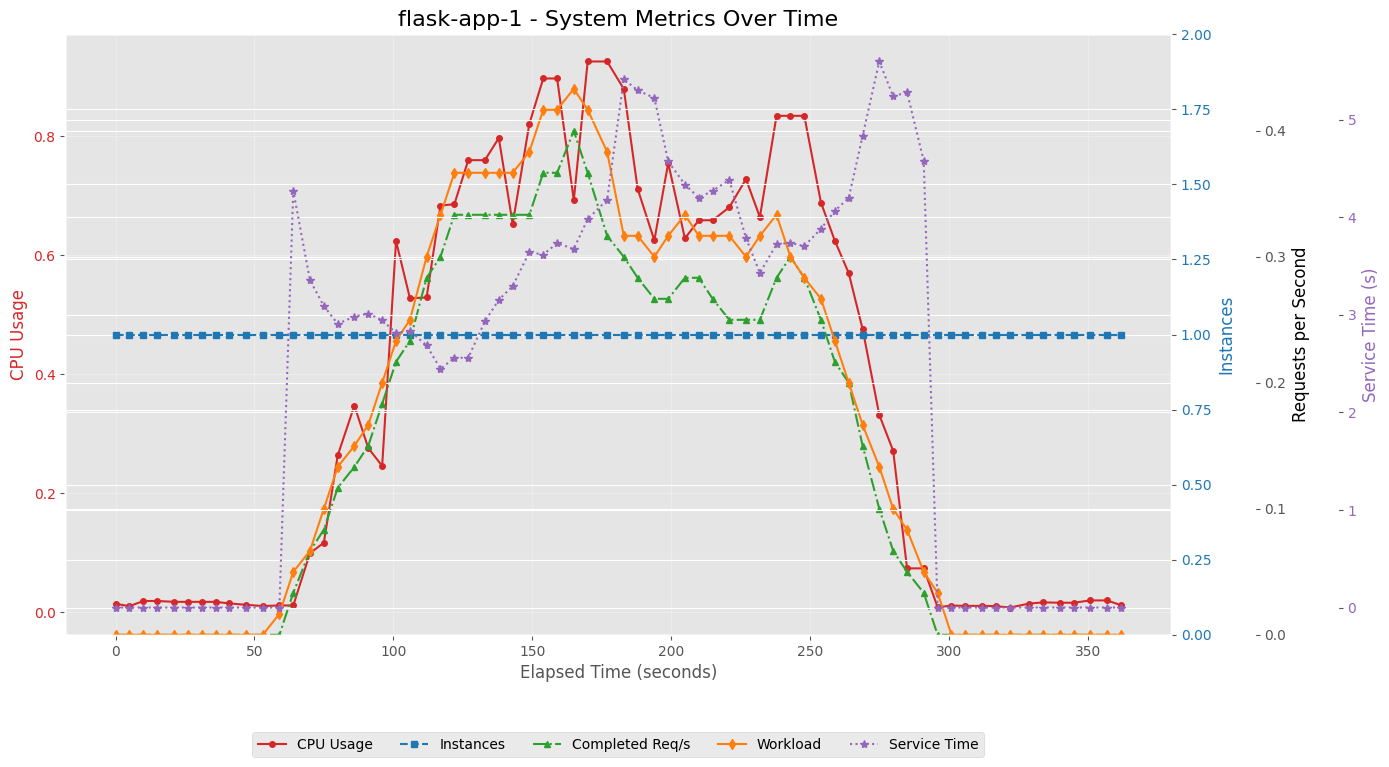

In [40]:
file_path = 'flask-app-1_instance_history.json'
plot_metrics(file_path)

Analyzing data for: flask-app-2
Loaded 67 data points


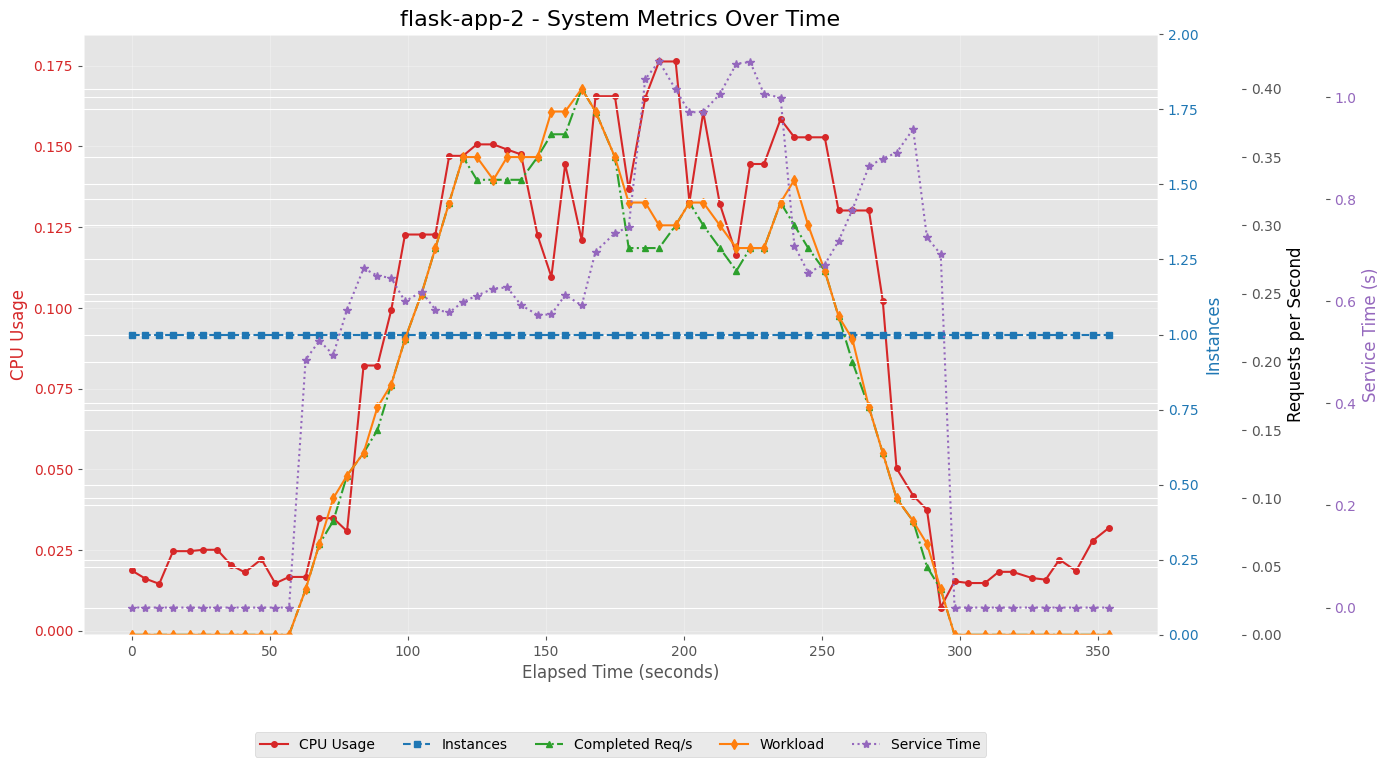

In [41]:
file_path = 'flask-app-2_instance_history.json'
plot_metrics(file_path)

Analyzing data for: flask-app-1
Loaded 78 data points


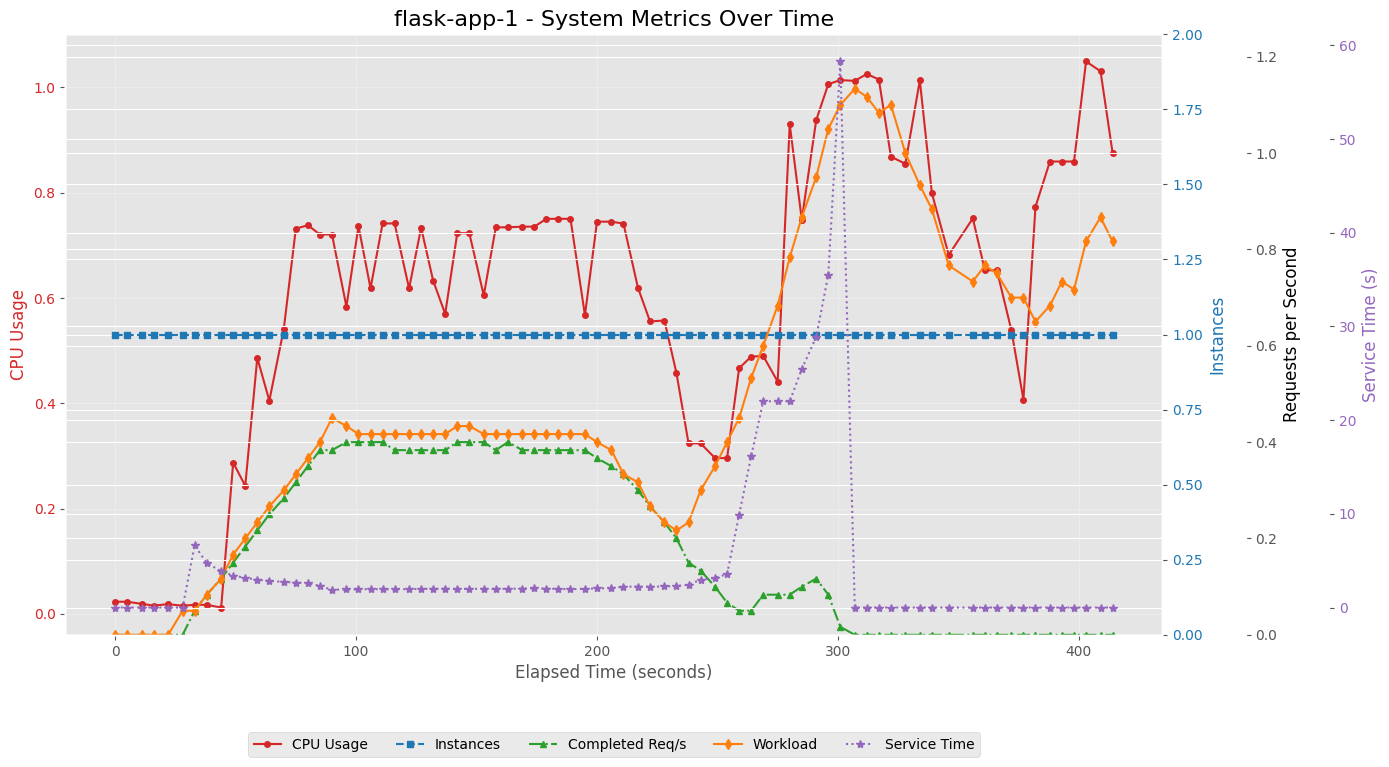

In [42]:
file_path = 'flask-app-1_instance_history-overload.json'
plot_metrics(file_path)

Analyzing data for: flask-app-2
Loaded 77 data points


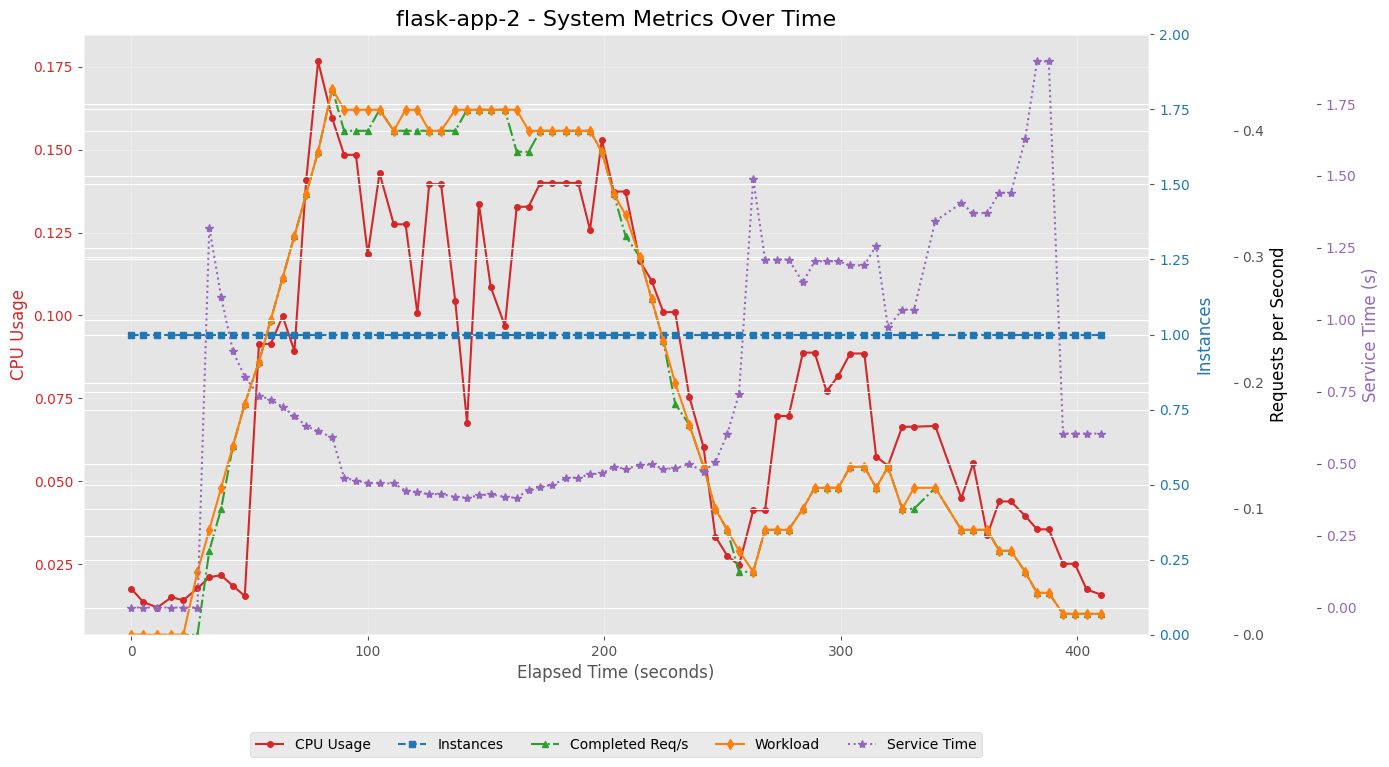

In [43]:
file_path = 'flask-app-2_instance_history-overload.json'
plot_metrics(file_path)

Analyzing data for: flask-app-1
Loaded 108 data points


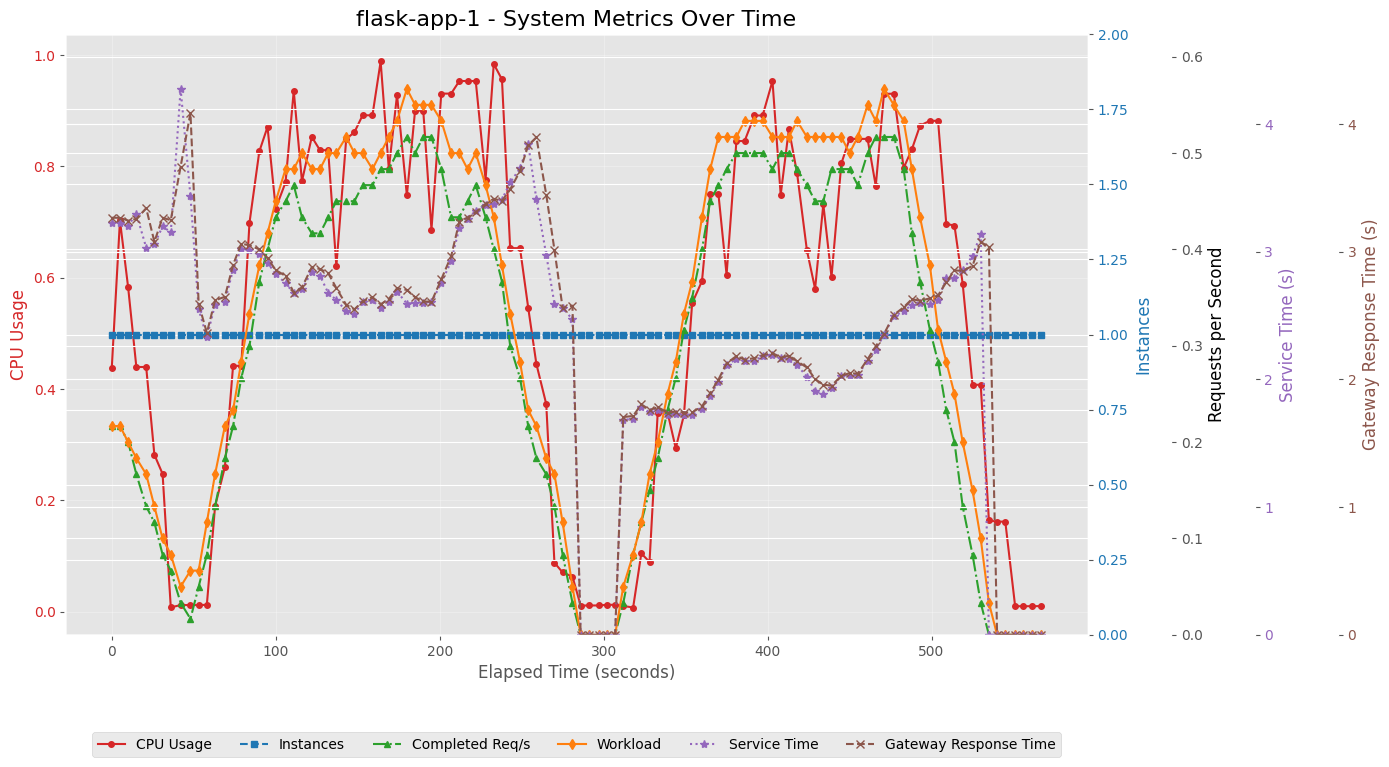

In [5]:
file_path = 'flask-app-1_instance_history.json'
plot_metrics(file_path)